# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from r2b_data import make_traj_r2bc , make_train_r2bc
from r2b_data import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy
from r2b_data import make_datasets_earth, make_datasets_solar, make_datasets_r2bc

from r2b import KineticEnergy_R2B, PotentialEnergy_R2B
from r2b import AngularMomentum0_R2B, AngularMomentum_R2B
from r2b import ConfigToPolar2D
from r2b import VectorError, EnergyError, AngularMomentumError
from r2b import Motion_R2B

from r2bc_model_math import make_position_model_r2bc_math, make_model_r2bc_math
from r2bc_model_nn import make_position_model_r2bc_nn# , make_physics_model_r2bc_nn
from r2bc_model_nn import make_model_r2bc_nn, compile_and_fit

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Create distribution strategy
# This isn't working properly for training in Michael-PC (Windows 10)
# but does work for evaluating (with no real benefit though)
# strat = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1'])

# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/r2bc.pickle'
vartbl = load_vartbl(fname)

In [6]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r0=1.0, theta0=0.0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

In [7]:
# fig, ax = plot_orbit_q(data_earth)

In [8]:
# fig, ax = plot_orbit_v(data_earth)

In [9]:
# fig, ax = plot_orbit_a(data_earth)

In [10]:
# fig, ax = plot_orbit_energy(data_earth)

### Generate data sets and an example batch

In [11]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=1000, vt_split=0.20, n_years=2)

# Create DataSet objects for solar system type orbits (a between 0.25 and 32.0)
ds_solar_trn, ds_solar_val, ds_solar_tst = make_datasets_solar(n_traj=100000, vt_split=0.01, n_years=2)

# Create DataSet objects for jupiter orbits only (a=5.2, e=0)
ds_jup_trn, ds_jup_val, ds_jup_tst = make_datasets_r2bc(n_traj=1000, vt_split=0.20, 
                                                        n_years=2, r_min=5.2, r_max=5.2, seed=42, batch_size=64)

In [129]:
# Example batch
batch_in, batch_out = list(ds_earth_val.take(1))[0]
# batch_in.keys()
# batch_out.keys()

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
mu = batch_in['mu']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
L = batch_out['L']

print(f'Example batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'mu = {mu.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'L  = {L.shape}')

Example batch sizes:
t  = (64, 731)
q0 = (64, 2)
v0 = (64, 2)
mu = (64, 1)
q  = (64, 731, 2)
v  = (64, 731, 2)
a  = (64, 731, 2)
H  = (64, 731)
L  = (64, 731)


In [13]:
batch_size = 64
traj_size = 731

tf.debugging.assert_shapes(
    shapes = {
    # Inputs
    t: (batch_size, traj_size),
    q0: (batch_size, 2),
    v0: (batch_size, 2),
    mu: (batch_size, 1),
    # Outputs
    q: (batch_size, traj_size, 2),
    v: (batch_size, traj_size, 2),
    a: (batch_size, traj_size, 2),
    q0_rec: (batch_size, 2),
    v0_rec: (batch_size, 2),
    H: (batch_size, traj_size),
    L: (batch_size, traj_size),
    })

**Call layers with physics computations**

In [14]:
T = KineticEnergy_R2B()(v)
T.shape

TensorShape([64, 731])

In [15]:
U = PotentialEnergy_R2B()([q, mu])
U.shape

TensorShape([64, 731])

In [16]:
L = AngularMomentum_R2B()([q, v])
L.shape

TensorShape([64, 731])

In [17]:
L0 = AngularMomentum0_R2B()([q0, v0])
L0.shape

TensorShape([64, 1])

**Conversion of initial configuration to polar coordinates**

In [18]:
r0, theta0, omega0 = ConfigToPolar2D()([q0, v0])
print(f'shape of polar batches')
print(f'r0 : {r0.shape}')
print(f'theta0 : {theta0.shape}')
print(f'omega0 : {omega0.shape}')

shape of polar batches
r0 : (64, 1)
theta0 : (64, 1)
omega0 : (64, 1)


### Mathematical Model
**Compute position as a function of time from initial polar coordinates**

In [19]:
position_model_math = make_position_model_r2bc_math(traj_size)

In [20]:
qx, qy = position_model_math([t, r0, theta0, omega0])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

qx = (64, 731, 1)
qy = (64, 731, 1)


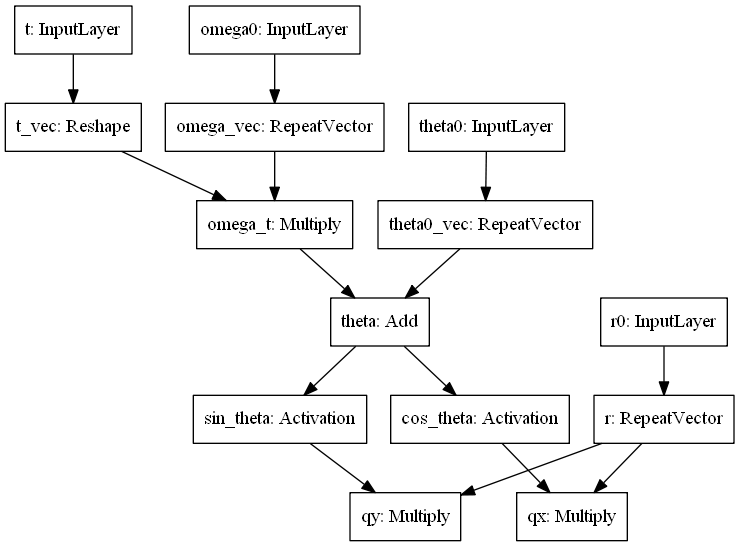

In [21]:
keras.utils.plot_model(position_model_math)

In [22]:
position_model_math.summary()

Model: "model_r2bc_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
omega0 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 731)]        0                                            
__________________________________________________________________________________________________
omega_vec (RepeatVector)        (None, 731, 1)       0           omega0[0][0]                     
__________________________________________________________________________________________________
t_vec (Reshape)                 (None, 731, 1)       0           t[0][0]                          
____________________________________________________________________________________

**Motion Model: Compute v and a from q using automatic differentiation**<br>
Factory function that accepts any position model<br>
Instantiated here from mathematical position model

In [23]:
motion_model_math = Motion_R2B(position_model=position_model_math, name='motion_model')

In [24]:
q, v, a = motion_model_math([t, r0, theta0, omega0])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 2)
v: (64, 731, 2)
a: (64, 731, 2)


**Full physics model: computes energy and angular momentum from q, v**<br>
Factory function that accepts any position model.<br>
Instantiated here from mathematical position model.

In [25]:
model_math = make_model_r2bc_math()

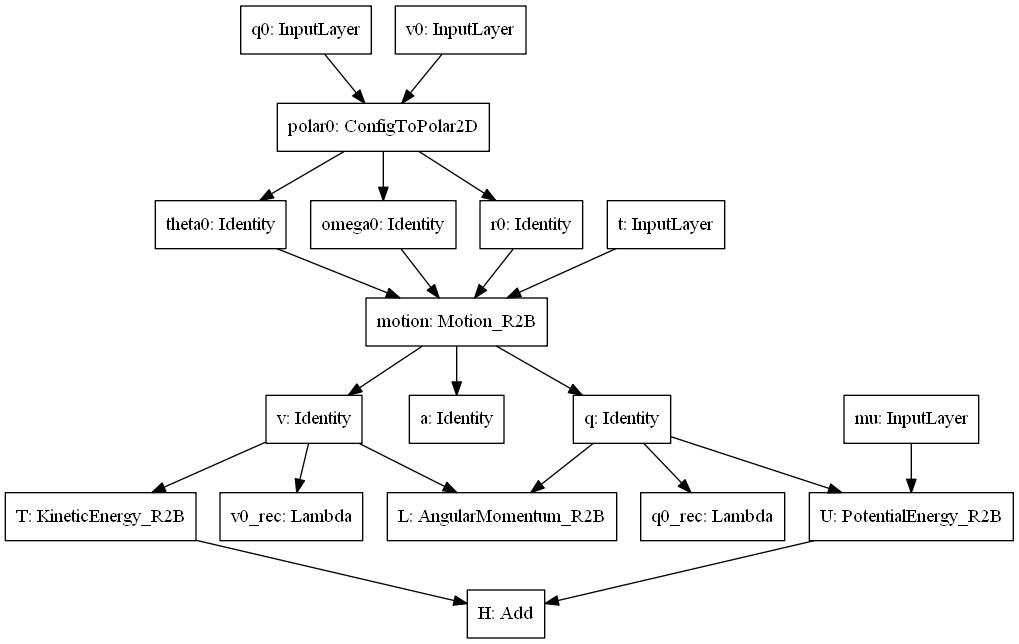

In [26]:
keras.utils.plot_model(model_math)

In [27]:
model_math.summary()

Model: "model_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
polar0 (ConfigToPolar2D)        ((None, 1), (None, 1 0           q0[0][0]                         
                                                                 v0[0][0]                         
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 731)]        0                                   

## Review outputs of math model

In [28]:
q, v, a, q0_rec, v0_rec, H, L  = model_math([t, q0, v0, mu])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'L = {L.shape}')

model output shapes:
q = (64, 731, 2)
v = (64, 731, 2)
a = (64, 731, 2)
q0_rec = (64, 2)
v0_rec = (64, 2)
H = (64, 731)
L = (64, 731)


In [29]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H'),
        # 'H': keras.losses.MeanSquaredError(name='H_loss'),
        'L': AngularMomentumError(name='L'),
        # 'L': keras.losses.MeanSquaredError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0}

In [30]:
# Compile the mathematical model on a single GPU
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [31]:
# Compile the mathematical model for parallel GPUs
# with strat.scope():
#     model_math_par = make_model_r2bc_analytic()
#     model_math_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [32]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_solar_val)

16/16 [==============================] - 1s 69ms/step - loss: 1.4414e-13 - q_loss: 2.7181e-14 - v_loss: 3.1565e-14 - a_loss: 2.7155e-14 - q0_rec_loss: 3.5868e-15 - v0_rec_loss: 6.9722e-15 - H_loss: 3.7404e-14 - L_loss: 1.0273e-14


[1.4413695431498533e-13,
 2.7181001e-14,
 3.1564974e-14,
 2.7154841e-14,
 3.5868444e-15,
 6.9721903e-15,
 3.7404148e-14,
 1.027296e-14]

**Timing of math model on single vs. multiple GPU**

In [33]:
def time_model_eval(model, ds, batches=None, time_mean=None):
    """Time a model to evaluate a dataset"""
    t0 = time.time()
    if batches is None:
        model.evaluate(ds)
    else:
        model.evaluate(ds.take(batches))
    t1 = time.time()
    elapsed = t1 - t0
    print(f'Elapsed Time: {elapsed:5.3f} sec')
    if time_mean is not None:
        delta = (elapsed - time_mean)
        print(f'Time Delta:   {delta:+5.3f} sec')

In [34]:
# Time the single GPU math model
# time_model_eval(model_math, ds_solar_trn)

In [35]:
# Time the double GPU math model
# time_model_eval(model_math_par, ds_solar_trn)

## Neural Net Model

In [36]:
position_model_nn = make_position_model_r2bc_nn([64, 16])

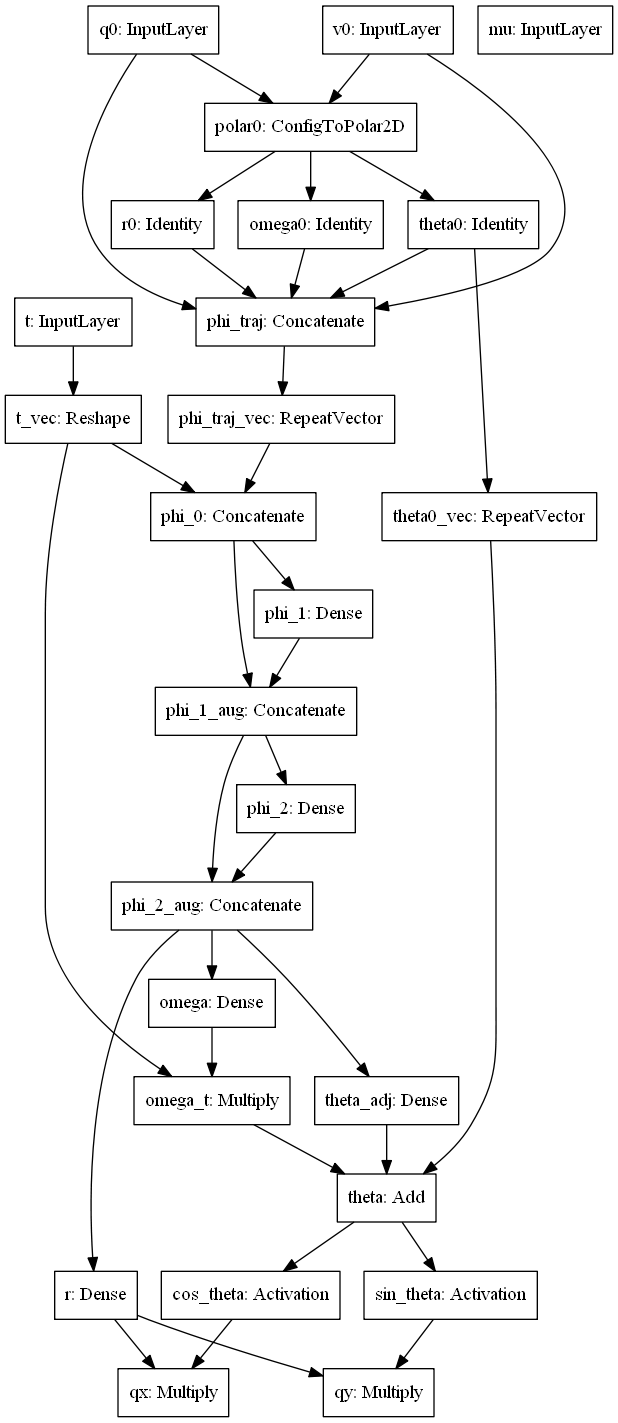

In [37]:
keras.utils.plot_model(position_model_nn)

In [38]:
position_model_nn.summary()

Model: "model_r2bc_position_nn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
polar0 (ConfigToPolar2D)        ((None, 1), (None, 1 0           q0[0][0]                         
                                                                 v0[0][0]                         
__________________________________________________________________________________________________
r0 (Identity)                   (None, 1)            0           polar0[0][0]

In [39]:
qx, qy = position_model_nn([t, q0, v0, mu])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

qx = (64, 731, 1)
qy = (64, 731, 1)


In [40]:
motion_model_nn = Motion_R2B(position_model=position_model_nn, name='motion_model_nn')

In [41]:
q, v, a = motion_model_nn([t, q0, v0, mu])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 2)
v: (64, 731, 2)
a: (64, 731, 2)


### Train the neural net model

In [54]:
# Make the NN r2bc model
model_nn = make_model_r2bc_nn(hidden_sizes=[64, 16], skip_layers=True, traj_size=traj_size)

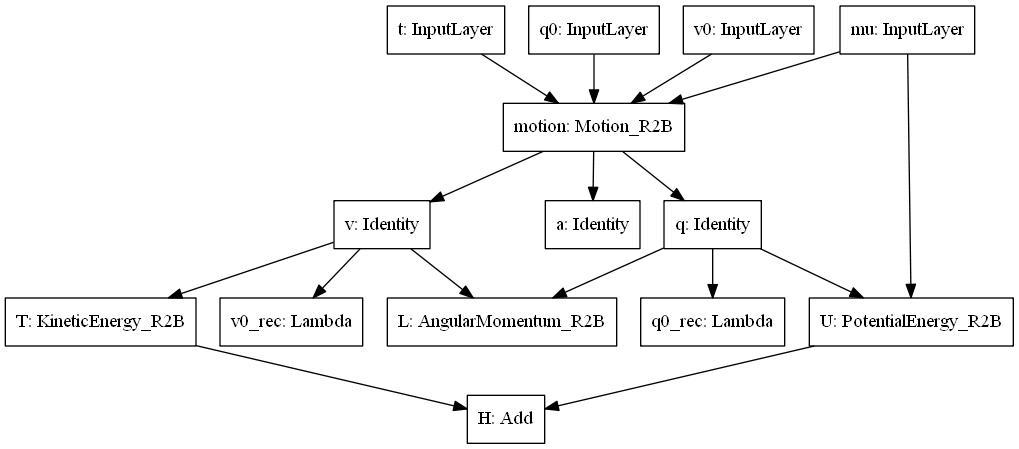

In [55]:
keras.utils.plot_model(model_nn)

In [56]:
# model_nn.summary()

In [128]:
q, v, a, q0_rec, v0_rec, H, L = model_nn([t, q0, v0, mu])
print('shape of model_nn outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')
print(f'q0_rec: {q0_rec.shape}')
print(f'v0_rec: {v0_rec.shape}')
print(f'H: {H.shape}')
print(f'L: {L.shape}')

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [1,731,1] vs. shape[1] = [731,731,7] [Op:ConcatV2] name: concat

In [58]:
# Experiment with learning rate
optimizer = keras.optimizers.Adam(learning_rate=5.0E-4)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=0.010, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'L': AngularMomentumError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0,}

In [59]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [60]:
# Evaluate the NN model on the solar system data set
model_nn.evaluate(ds_solar_val)

16/16 [==============================] - 4s 253ms/step - loss: 11.8127 - q_loss: 0.9257 - v_loss: 1.0000 - a_loss: 0.6157 - q0_rec_loss: 0.8122 - v0_rec_loss: 1.0000 - H_loss: 6.4591 - L_loss: 1.0000


[11.812650859355927,
 0.92569345,
 1.0,
 0.6156558,
 0.81216794,
 1.0,
 6.4591336,
 1.0]

In [51]:
# Set up training
epochs = 40
save_freq = 'epoch'

In [61]:
hist = compile_and_fit(model=model_nn, 
                       ds=ds_solar_trn, 
                       epochs=epochs,
                       loss=loss, 
                       optimizer=optimizer,
                       metrics=metrics,
                       save_freq=save_freq,
                       prev_history = None)

Epoch 1/100
1561/1563 [============================>.] - ETA: 0s - loss: 1.4372 - q_loss: 0.2137 - v_loss: 0.0892 - a_loss: 0.1490 - q0_rec_loss: 0.1210 - v0_rec_loss: 0.0593 - H_loss: 0.6727 - L_loss: 0.1323
Epoch 0001; loss 1.44e+00; elapsed 0:01:17
1563/1563 [==============================] - 75s 48ms/step - loss: 1.4357 - q_loss: 0.2135 - v_loss: 0.0891 - a_loss: 0.1489 - q0_rec_loss: 0.1208 - v0_rec_loss: 0.0592 - H_loss: 0.6720 - L_loss: 0.1321
Epoch 2/100
1561/1563 [============================>.] - ETA: 0s - loss: 0.1016 - q_loss: 0.0272 - v_loss: 0.0202 - a_loss: 0.0219 - q0_rec_loss: 0.0056 - v0_rec_loss: 0.0056 - H_loss: 0.0164 - L_loss: 0.0047 ETA: 2s - loss: 0.1026 - q_loss: 0.0279 - v_loss: 0.0205 - a_loss: 0.02
Epoch 0002; loss 1.02e-01; elapsed 0:02:23
1563/1563 [==============================] - 63s 40ms/step - loss: 0.1017 - q_loss: 0.0272 - v_loss: 0.0202 - a_loss: 0.0219 - q0_rec_loss: 0.0056 - v0_rec_loss: 0.0056 - H_loss: 0.0164 - L_loss: 0.0047
Epoch 3/100
1562/1

1562/1563 [============================>.] - ETA: 0s - loss: 0.0164 - q_loss: 2.1870e-04 - v_loss: 0.0019 - a_loss: 0.0022 - q0_rec_loss: 1.9804e-04 - v0_rec_loss: 0.0019 - H_loss: 0.0078 - L_loss: 0.0021
Epoch 0013; loss 1.64e-02; elapsed 0:14:30
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0164 - q_loss: 2.1882e-04 - v_loss: 0.0019 - a_loss: 0.0022 - q0_rec_loss: 1.9830e-04 - v0_rec_loss: 0.0019 - H_loss: 0.0078 - L_loss: 0.0021
Epoch 14/100
1562/1563 [============================>.] - ETA: 0s - loss: 0.0129 - q_loss: 2.0161e-04 - v_loss: 0.0015 - a_loss: 0.0017 - q0_rec_loss: 1.8381e-04 - v0_rec_loss: 0.0014 - H_loss: 0.0063 - L_loss: 0.0017             -
Epoch 0014; loss 1.29e-02; elapsed 0:15:37
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0129 - q_loss: 2.0157e-04 - v_loss: 0.0015 - a_loss: 0.0017 - q0_rec_loss: 1.8381e-04 - v0_rec_loss: 0.0014 - H_loss: 0.0063 - L_loss: 0.0017
Epoch 15/100
1562/1563 [============================>.]

1562/1563 [============================>.] - ETA: 0s - loss: 0.0116 - q_loss: 1.3759e-04 - v_loss: 0.0013 - a_loss: 0.0015 - q0_rec_loss: 1.2282e-04 - v0_rec_loss: 0.0013 - H_loss: 0.0057 - L_loss: 0.0015
Epoch 0029; loss 1.17e-02; elapsed 0:32:30
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0117 - q_loss: 1.3786e-04 - v_loss: 0.0013 - a_loss: 0.0015 - q0_rec_loss: 1.2300e-04 - v0_rec_loss: 0.0013 - H_loss: 0.0057 - L_loss: 0.0015
Epoch 30/100
1562/1563 [============================>.] - ETA: 0s - loss: 0.0141 - q_loss: 1.4360e-04 - v_loss: 0.0017 - a_loss: 0.0019 - q0_rec_loss: 1.2902e-04 - v0_rec_loss: 0.0016 - H_loss: 0.0068 - L_loss: 0.0019
Epoch 0030; loss 1.42e-02; elapsed 0:33:37
1563/1563 [==============================] - 65s 41ms/step - loss: 0.0142 - q_loss: 1.4389e-04 - v_loss: 0.0017 - a_loss: 0.0019 - q0_rec_loss: 1.2936e-04 - v0_rec_loss: 0.0016 - H_loss: 0.0069 - L_loss: 0.0019
Epoch 31/100
1562/1563 [============================>.] - ETA: 0s - l

1562/1563 [============================>.] - ETA: 0s - loss: 0.0146 - q_loss: 1.3101e-04 - v_loss: 0.0018 - a_loss: 0.0021 - q0_rec_loss: 1.1517e-04 - v0_rec_loss: 0.0018 - H_loss: 0.0067 - L_loss: 0.0019 - ETA: 44s - loss: 0.0264 - q_loss: 2.4759e-04 - v_loss: 0.0033 - a_loss: 0.0039 - q0_rec_loss: 2.1815e-04 - v0_re - ETA: 40s - loss: 0.0228 - q_loss: 2.2166e-04 - v_loss: 0.0028 - a_loss: 0.0033 - q0_rec_loss: 1.9599e-04 - v0_re - ETA: 37s - loss: 0.0199 - q_loss: 1.9802e-04 - v_lo - ETA: 16s - loss: 0.0119 - q_loss: 1.3123e-04 - v_loss: 0.0015 - a_loss: 0.0017 - q0_rec_loss: 1.1703e-04 - v0_rec_loss: 0.0014 - H_loss: - ETA: 14s - loss: 0.0130 - q_loss: 1.3068e-04 - v_ - ETA: 8s - loss: 0.0130 - q_loss: 1.2895e-04 - v_loss: 0.0016 - a_loss: 0.0019 - q0_rec_loss: 1.1428e-04 - v0_rec_loss: 0.0015 - - ETA: 7s - loss: 0.0129 - q_loss: 1.2742e-04 - v_loss: 0.0016 - a_loss: 0.0018 - q0_rec_loss: 1.1291e-04 - v0_rec_loss: 0.0015 - H_loss: 0.0060 -  - ETA: 6s - loss: 0.0128 - q_loss: 1.2663e

1562/1563 [============================>.] - ETA: 0s - loss: 0.0095 - q_loss: 9.2780e-05 - v_loss: 0.0011 - a_loss: 0.0013 - q0_rec_loss: 8.3370e-05 - v0_rec_loss: 0.0011 - H_loss: 0.0046 - L_loss: 0.0012 ETA: 0s - loss: 0.0095 - q_loss: 9.3289e-05 - v_loss: 0.0011 - a_loss: 0.0013 - q0_rec_loss: 8.3837e-05 - v0_rec_loss: 0.0011 - H_loss: 0.0047 
Epoch 0057; loss 9.47e-03; elapsed 1:04:56
1563/1563 [==============================] - 64s 41ms/step - loss: 0.0095 - q_loss: 9.2730e-05 - v_loss: 0.0011 - a_loss: 0.0013 - q0_rec_loss: 8.3327e-05 - v0_rec_loss: 0.0011 - H_loss: 0.0046 - L_loss: 0.0012
Epoch 58/100
1562/1563 [============================>.] - ETA: 0s - loss: 0.0122 - q_loss: 1.1341e-04 - v_loss: 0.0015 - a_loss: 0.0017 - q0_rec_loss: 1.0158e-04 - v0_rec_loss: 0.0014 - H_loss: 0.0059 - L_loss: 0.0016
Epoch 0058; loss 1.22e-02; elapsed 1:07:16
1563/1563 [==============================] - 138s 88ms/step - loss: 0.0122 - q_loss: 1.1342e-04 - v_loss: 0.0015 - a_loss: 0.0017 - q0_r

KeyboardInterrupt: 

In [62]:
fig, ax = plot_loss_hist(hist, '[64, 16]')

NameError: name 'hist' is not defined

In [214]:
def plot_orbit_nn_q(model_nn, ds, k=0):
    """Plot the orbit position in a training sample"""

    # Take 1 batch
    batch_in, batch_out = list(ds.take(1))[0]

    # Combined dict
    data = {**batch_in, **batch_out}

    # Unpack data; these are batches
    t = data['t']
    q0 = data['q0']
    v0 = data['v0']
    mu = data['mu']
    q = data['q']

    # Run NN
    q_nn, v_nn  = model_nn([t, q0, v0, mu])[0:2]

    # Unpack ground truth
    t = t[k, :].numpy()
    qx = q[k, :, 0].numpy()
    qy = q[k, :, 1].numpy()

    # Unpack NN outputs
    qx_nn = q_nn[k, :, 0].numpy()
    qy_nn = q_nn[k, :, 1].numpy()
    vx_nn = v_nn[k, :, 0].numpy()
    vy_nn = v_nn[k, :, 1].numpy()

    # Compute the distance r
    r = np.linalg.norm(q[k], axis=1)
    r_nn = np.linalg.norm(q_nn[k], axis=1)

    # Plot the x and y coordinate
    fig, ax = plt.subplots(figsize=[16, 9])
    ax.set_title('Orbit Position')
    ax.set_xlabel('t - years')
    ax.set_ylabel('q - AU')
    ax.set_xticks(np.arange(0.0, np.max(t)+0.25, 0.25))
    # Ground truth
    ax.plot(t, qx, color='blue', label='qx', linewidth=4.0)
    ax.plot(t, qy, color='green', label='qy', linewidth=4.0)
    # ax.plot(t, r,  color='purple', label='r')
    # NN predictions
    ax.plot(t, qx_nn, color='red', label='qx_nn', linewidth=2.0)
    ax.plot(t, qy_nn, color='orange', label='qy_nn', linewidth=2.0)
    # ax.plot(t, r,  color='purple', linewidth=1.5)
    ax.grid()
    ax.legend()

    return fig, ax

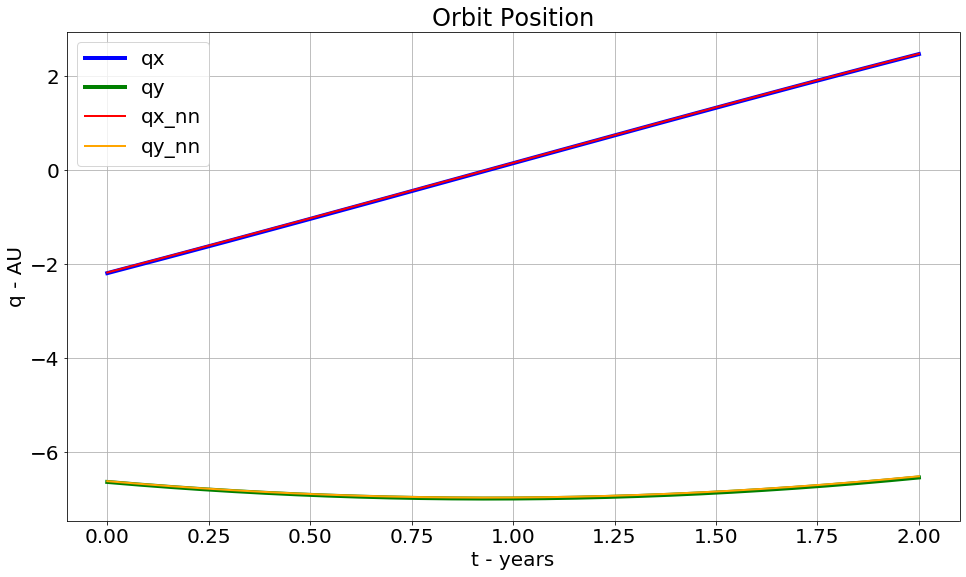

In [221]:
fig, ax = plot_orbit_nn_q(model_nn, ds, 5)